# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [65]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

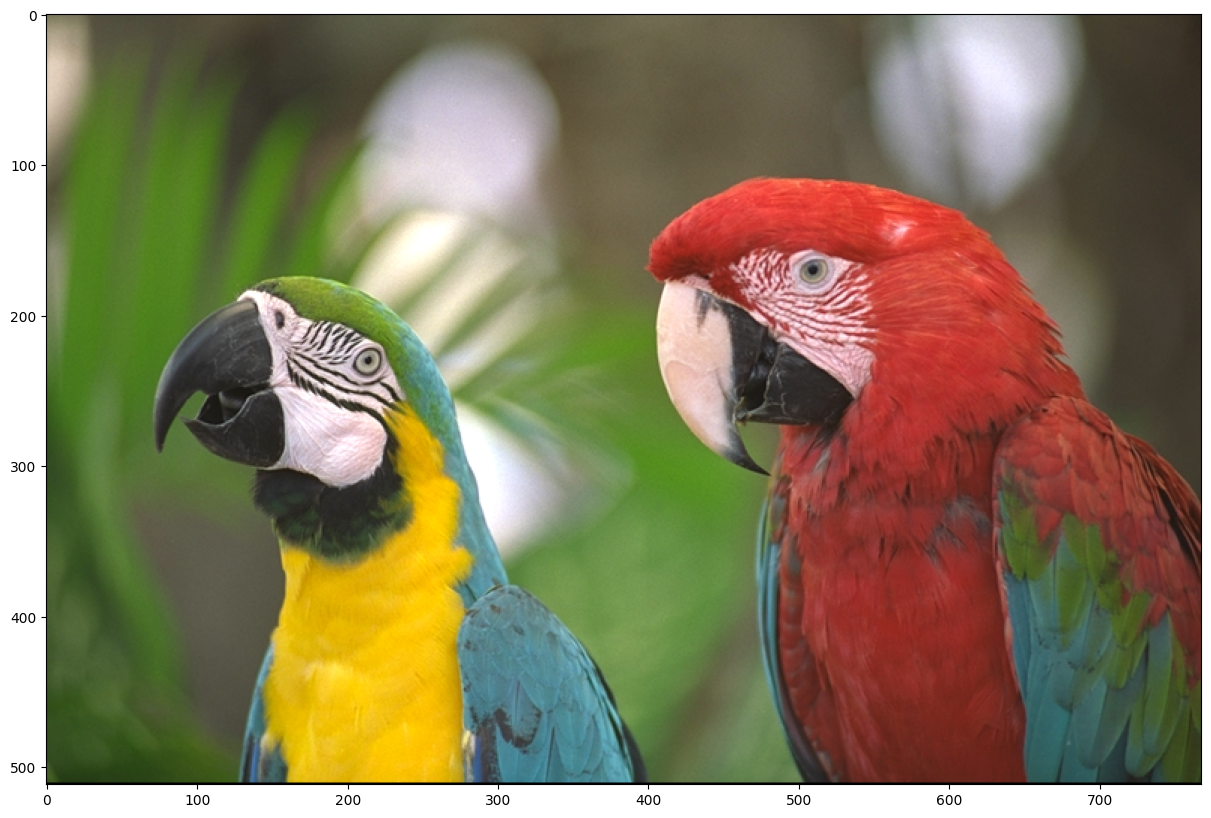

In [66]:
# Load image
img = cv2.imread('data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [67]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [68]:
def calculate_closest_color(pixel, colors):
    distances = np.linalg.norm(colors - pixel, axis=1)
    closest_color_index = np.argmin(distances)
    return colors[closest_color_index]

def quantize_image(img, colors):
    # Cast the image to float
    img_float = np.copy(img).astype(np.float32)
    
    # Prepare for quantization
    rows, cols, channels = img_float.shape
    quantized = np.zeros_like(img_float)
    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img_float[r, c, :]
    
            # Find the closest colour from the palette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = calculate_closest_color(pixel, colors)
    
            # Apply quantization
            quantized[r, c, :] = new_pixel
    
    return quantized

quantized = quantize_image(img, colors)

(<Axes: title={'center': 'Quantized'}>,
 Text(0.5, 1.0, 'Quantized'))

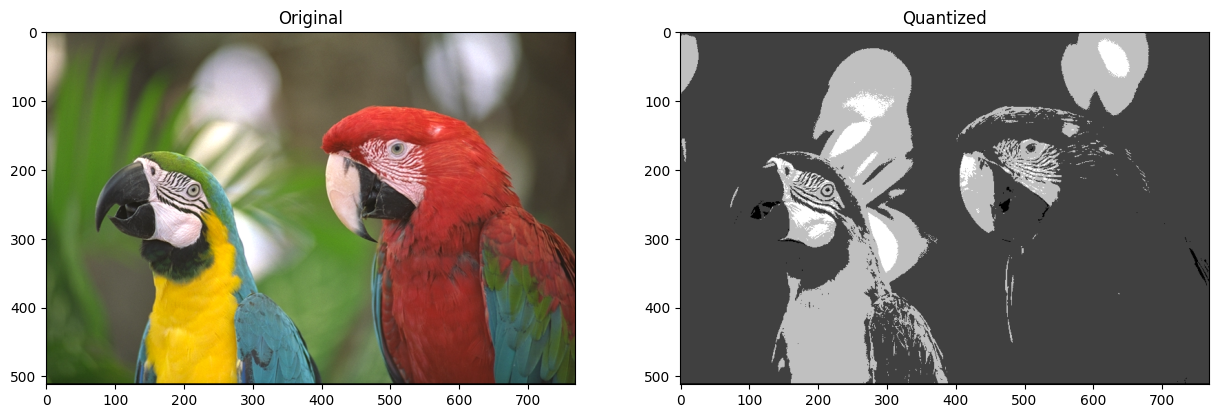

In [69]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(quantized.astype(np.uint8)), plt.title('Quantized')

In [70]:
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)


# Compute average quantization error
avg_quant_error = psnr(img, quantized)
print('PSNR for quantized', avg_quant_error, 'dB')

PSNR for quantized 14.826061453276782 dB


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [71]:
# Make a temporal copy of the original image, we will need it for error diffusion
def dither_image(img, colors):
    img_tmp = np.copy(img).astype(np.float32)
    dithering = np.zeros_like(img)

    rows, cols, channels = img_tmp.shape

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]
            # Find the closest colour from the palette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = calculate_closest_color(pixel, colors)
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error according to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r+1, c, :] += quant_error * np.array([7/16, 7/16, 7/16])
            img_tmp[r-1, c+1, :] += quant_error * np.array([3/16, 3/16, 3/16])
            img_tmp[r, c+1, :] += quant_error * np.array([5/16, 5/16, 5/16])
            img_tmp[r+1, c+1, :] += quant_error * np.array([1/16, 1/16, 1/16])
            
            # Apply dithering
            dithering[r, c, :] = new_pixel
    
    return dithering

dithering = dither_image(img, colors)

(<Axes: title={'center': 'dithering'}>,
 Text(0.5, 1.0, 'dithering'))

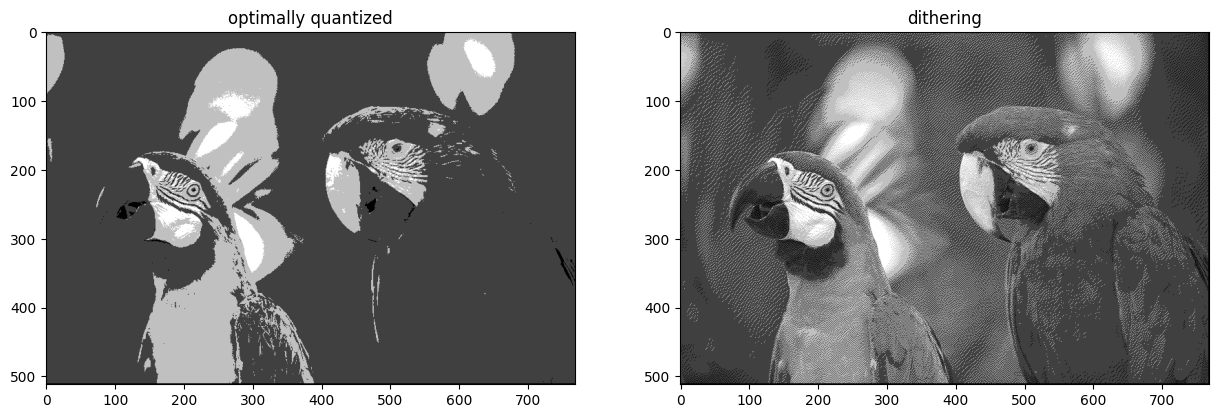

In [72]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8)), plt.title('optimally quantized') # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8)), plt.title('dithering')   # dithering

In [73]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering.astype(np.uint8))
print('PSNR for dithering', avg_dith_error, 'dB')

PSNR for dithering 13.27339496184867 dB


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Answers
* Более высокая ошибка кварнтификации у optimally quantized, чем у Floyd-Steinberg Dithering, судя по расчету, хотя по качетву Floyd-Steinberg Dithering выглядит лучше
* Картинка, обработанная по алгоритму Floyd-Steinberg Dithering выглядит лучше, хотя ее PSNR  и ниже
* Для палитры 2х цветов - черный и белый:

PSNR for quantized 8.787833619841734 dB
PSNR for dithering 6.564683065530983 dB


(<Axes: title={'center': 'dithering'}>,
 Text(0.5, 1.0, 'dithering'))

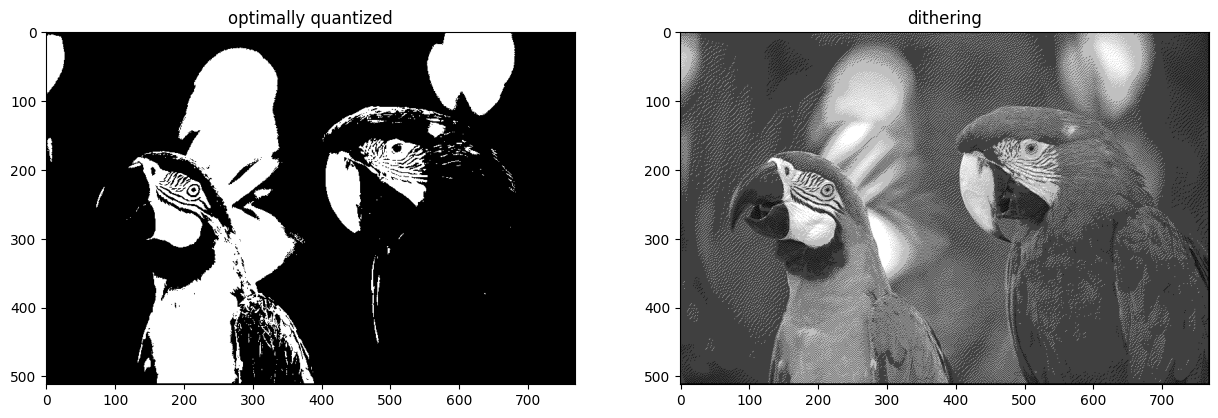

In [75]:
colors_black_white = np.array([[0, 0, 0], [255, 255, 255]])

quantized = quantize_image(img, colors_black_white)

dithered = dither_image(img, colors_black_white)

print('PSNR for quantized', psnr(img, quantized), 'dB')
print('PSNR for dithering', psnr(img, dithered), 'dB')

plt.subplot(121), plt.imshow(quantized.astype(np.uint8)), plt.title('optimally quantized')
plt.subplot(122), plt.imshow(dithering.astype(np.uint8)), plt.title('dithering')

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [90]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors_16 = kmeans.cluster_centers_

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

PSNR for 16 colors (quantized):  26.646785711413045 dB
PSNR for 16 colors (dithered):  23.553651129874424 dB


(<Axes: title={'center': 'Dithered'}>,
 Text(0.5, 1.0, 'Dithered'))

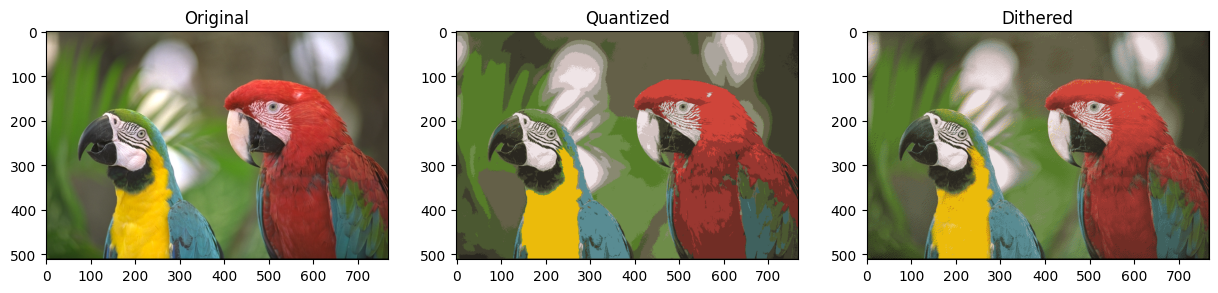

In [91]:
quantized = quantize_image(img, colors_16).astype(np.uint8)
dithered = dither_image(img, colors_16).astype(np.uint8)

# PSNR
print('PSNR for 16 colors (quantized): ', psnr(img, quantized), 'dB')
print('PSNR for 16 colors (dithered): ', psnr(img, dithered), 'dB')

plt.subplot(131), plt.imshow(img), plt.title('Original')
plt.subplot(132), plt.imshow(quantized), plt.title('Quantized')
plt.subplot(133), plt.imshow(dithered), plt.title('Dithered')

PSNR for 32 colors (quantized):  29.14742015709269 dB
PSNR for 32 colors (dithered):  25.741811955143213 dB


(<Axes: title={'center': 'Dithered'}>,
 Text(0.5, 1.0, 'Dithered'))

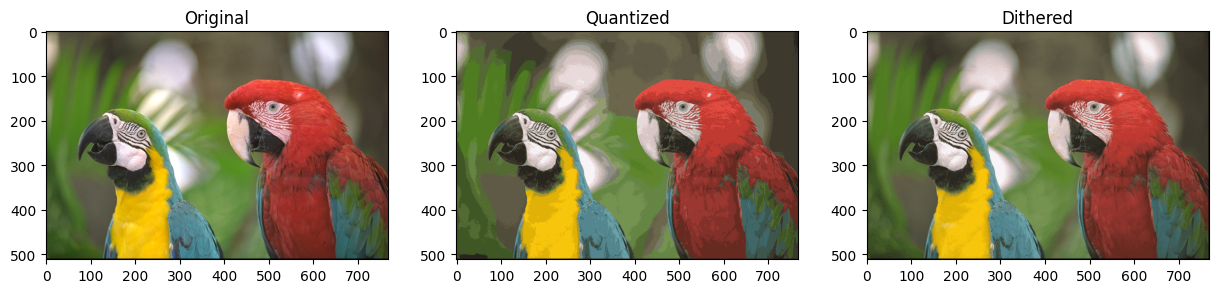

In [92]:
kmeans = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 3)))
colors_32 = kmeans.cluster_centers_

quantized = quantize_image(img, colors_32).astype(np.uint8)
dithered = dither_image(img, colors_32).astype(np.uint8)

# PSNR
print('PSNR for 32 colors (quantized): ', psnr(img, quantized), 'dB')
print('PSNR for 32 colors (dithered): ', psnr(img, dithered), 'dB')

plt.subplot(131), plt.imshow(img), plt.title('Original')
plt.subplot(132), plt.imshow(quantized), plt.title('Quantized')
plt.subplot(133), plt.imshow(dithered), plt.title('Dithered')

PSNR for 256 colors (quantized):  36.62068506926369 dB
PSNR for 256 colors (dithered):  30.371799021735526 dB


(<Axes: title={'center': 'Dithered'}>,
 Text(0.5, 1.0, 'Dithered'))

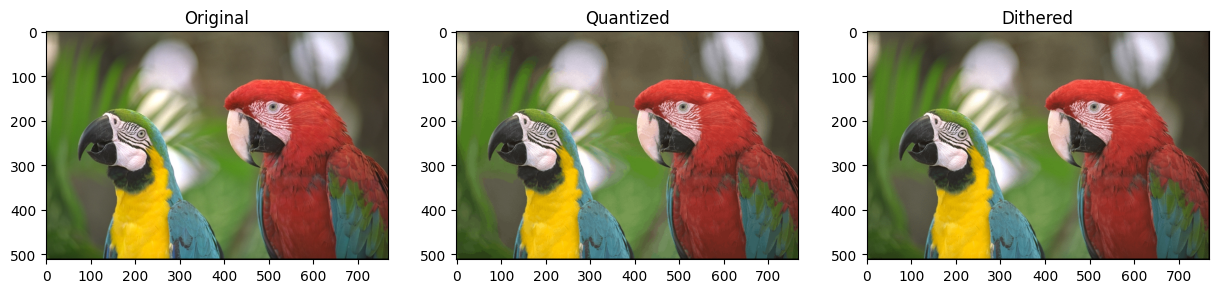

In [93]:
kmeans = KMeans(n_clusters=256).fit(np.reshape(img, (-1, 3)))
colors_256 = kmeans.cluster_centers_

quantized = quantize_image(img, colors_256).astype(np.uint8)
dithered = dither_image(img, colors_256).astype(np.uint8)

# PSNR
print('PSNR for 256 colors (quantized): ', psnr(img, quantized), 'dB')
print('PSNR for 256 colors (dithered): ', psnr(img, dithered), 'dB')

plt.subplot(131), plt.imshow(img), plt.title('Original')
plt.subplot(132), plt.imshow(quantized), plt.title('Quantized')
plt.subplot(133), plt.imshow(dithered), plt.title('Dithered')

Чем больше цветов в цветовой палитре квантификации, тем качетсвеннее выглядит результат квантификации, обработанная по алгоритму Floyd-Steinberg Dithering в каждом случае визуально выглядит лучше, чем оптимальная квантификация, хотя каждый раз ее PSNR меньше